In [9]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import nltk
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
import scipy.cluster.hierarchy as sch
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Prepare lyrics data

In [3]:
# Get lyrics data
song_lyrics = pd.read_csv('merge_w_lyrics_full.csv')[['title','artist_x','lyrics','hit']].dropna().reset_index(drop=True)

# Clean lyrics
song_lyrics['lyrics'] = song_lyrics['lyrics'].str.replace('\n', ' ').replace('.', '').replace(',', '').replace('-', ' ').replace("'", '').replace('"', '').replace('?', '').replace('URLCopyEmbedCopy','').replace('URLCopyEmbedCopy'.lower(),'')

song_lyrics

,title,artist_x,lyrics,hit
0,"10,000 Reasons (Bless the Lord)",Matt Redman,"Bless the Lord, O my soul, O my soul Worship H...",0.0
1,100 Proof,Kellie Pickler,Ain't no rain as cold as the look she just gav...,0.0
2,101,Alicia Keys,You used to the sound of a heart that's breaki...,0.0
3,110%,Jessie Ware,Carving my initials on your forehead Now if y...,0.0
4,1313,The Big Pink,"Convey your thoughts, translate them well Say ...",0.0
...,...,...,...,...
20977,Danny Phantom,Trippie Redd,"Yeah, first I wanna show you some of this dama...",1.0
20978,What's Wrong,Rod Wave,You know what they gon' say When the world tur...,1.0
20979,Demon Time,Trippie Redd,"Ha (Ha-ha) Demon time, nigga (Yeah) Gang, uh (...",1.0
20980,Tick Tock,Young Thug,"Yeah, Spider, yeah (Slime) Okay, shit, I just...",1.0


In [4]:
# tokenize and stem lyrics
tokenizer = RegexpTokenizer(r'\w+')

# Instantiate stemmer
stemmer = SnowballStemmer('english')

# List to append stemmed words
stemmed = []        
# List to append tokenized words
tokenized = []

# Create a for loop to iterate through all the rows in specific column
for i in song_lyrics['lyrics']:                          

    # Converting lyrics text to tokens
    tokens = tokenizer.tokenize(i.lower()) 
    tokenized.append(tokens)

    # Stemming all tokens
    stems = [stemmer.stem(token) for token in tokens]  
    # Appending stems to stemmed list
    stemmed.append(stems)                                         

# Creating new dataframe columns
song_lyrics['tokenized_lyrics'] = [' '.join(i) for i in tokenized]    
song_lyrics['stemmed_lyrics'] = [' '.join(i) for i in stemmed]

song_lyrics

,title,artist_x,lyrics,hit,tokenized_lyrics,stemmed_lyrics
0,"10,000 Reasons (Bless the Lord)",Matt Redman,"Bless the Lord, O my soul, O my soul Worship H...",0.0,bless the lord o my soul o my soul worship his...,bless the lord o my soul o my soul worship his...
1,100 Proof,Kellie Pickler,Ain't no rain as cold as the look she just gav...,0.0,ain t no rain as cold as the look she just gav...,ain t no rain as cold as the look she just gav...
2,101,Alicia Keys,You used to the sound of a heart that's breaki...,0.0,you used to the sound of a heart that s breaki...,you use to the sound of a heart that s break i...
3,110%,Jessie Ware,Carving my initials on your forehead Now if y...,0.0,carving my initials on your forehead now if yo...,carv my initi on your forehead now if you re n...
4,1313,The Big Pink,"Convey your thoughts, translate them well Say ...",0.0,convey your thoughts translate them well say t...,convey your thought translat them well say tho...
...,...,...,...,...,...,...
20977,Danny Phantom,Trippie Redd,"Yeah, first I wanna show you some of this dama...",1.0,yeah first i wanna show you some of this damag...,yeah first i wanna show you some of this damag...
20978,What's Wrong,Rod Wave,You know what they gon' say When the world tur...,1.0,you know what they gon say when the world turn...,you know what they gon say when the world turn...
20979,Demon Time,Trippie Redd,"Ha (Ha-ha) Demon time, nigga (Yeah) Gang, uh (...",1.0,ha ha ha demon time nigga yeah gang uh gang ga...,ha ha ha demon time nigga yeah gang uh gang ga...
20980,Tick Tock,Young Thug,"Yeah, Spider, yeah (Slime) Okay, shit, I just...",1.0,yeah spider yeah slime okay shit i just woke u...,yeah spider yeah slime okay shit i just woke u...


In [6]:
# CountVectorizer
cv = CountVectorizer(input='content', 
                     stop_words='english',
                     lowercase=True,
                     strip_accents='ascii',
                     max_features=800)

dtm_cv = cv.fit_transform(song_lyrics['stemmed_lyrics'])

df_cv = pd.DataFrame(dtm_cv.toarray(),
                      columns=cv.get_feature_names(),
                      index=song_lyrics['title'])

# Filter non-alphabetic features
df_cv = df_cv[[c for c in df_cv.columns if c.isalpha()]]

# Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_cv_norm = pd.DataFrame(scaler.fit_transform(df_cv), columns=df_cv.columns)
df_cv_norm

,abl,abov,act,action,afraid,age,ago,ah,ain,air,...,wrong,ya,ye,yeah,year,yes,yo,york,young,zoe
0,-0.048123,-0.107832,-0.059671,-0.071446,-0.114788,-0.094534,-0.09665,-0.116677,-0.343075,-0.108646,...,-0.203243,-0.140176,-0.035054,-0.373963,0.181559,-0.116203,-0.128673,-0.061109,-0.135677,-0.031522
1,-0.048123,-0.107832,-0.059671,-0.071446,-0.114788,-0.094534,-0.09665,-0.116677,0.330870,-0.108646,...,-0.203243,-0.140176,-0.035054,-0.197272,-0.114875,0.381892,-0.128673,-0.061109,-0.135677,-0.031522
2,-0.048123,-0.107832,-0.059671,-0.071446,-0.114788,-0.094534,-0.09665,-0.116677,-0.343075,-0.108646,...,-0.203243,-0.140176,-0.035054,-0.197272,-0.114875,-0.116203,-0.128673,-0.061109,-0.135677,-0.031522
3,-0.048123,-0.107832,-0.059671,-0.071446,-0.114788,-0.094534,-0.09665,-0.116677,-0.343075,-0.108646,...,0.578793,-0.140176,-0.035054,-0.373963,-0.114875,-0.116203,-0.128673,-0.061109,-0.135677,-0.031522
4,-0.048123,-0.107832,-0.059671,-0.071446,-0.114788,-0.094534,-0.09665,-0.116677,-0.343075,-0.108646,...,-0.203243,-0.140176,-0.035054,-0.373963,0.181559,-0.116203,-0.128673,-0.061109,-0.135677,-0.031522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20977,-0.048123,-0.107832,-0.059671,-0.071446,-0.114788,-0.094534,-0.09665,-0.116677,-0.343075,-0.108646,...,-0.203243,-0.140176,-0.035054,5.280142,-0.114875,-0.116203,-0.128673,-0.061109,-0.135677,-0.031522
20978,-0.048123,-0.107832,0.291425,-0.071446,-0.114788,-0.094534,-0.09665,-0.116677,0.667842,-0.108646,...,1.360829,-0.140176,-0.035054,3.689925,-0.114875,-0.116203,-0.128673,-0.061109,0.222995,-0.031522
20979,-0.048123,-0.107832,-0.059671,-0.071446,-0.114788,-0.094534,-0.09665,-0.116677,1.341788,-0.108646,...,-0.203243,-0.140176,-0.035054,2.806471,-0.114875,-0.116203,-0.128673,-0.061109,-0.135677,-0.031522
20980,-0.048123,-0.107832,-0.059671,-0.071446,-0.114788,-0.094534,-0.09665,-0.116677,-0.343075,-0.108646,...,-0.203243,-0.140176,-0.035054,2.806471,0.181559,-0.116203,-0.128673,-0.061109,0.222995,-0.031522


In [7]:
# TfidfVectorizer
tfidf = TfidfVectorizer(input='content', 
                     stop_words='english',
                     lowercase=True,
                     strip_accents='ascii',
                     max_features=800)

dtm_tfidf = tfidf.fit_transform(song_lyrics['stemmed_lyrics'])

df_tfidf = pd.DataFrame(dtm_tfidf.toarray(),
                      columns=tfidf.get_feature_names(),
                      index=song_lyrics['title'])

df_tfidf = df_tfidf[[c for c in df_tfidf.columns if c.isalpha()]]

df_tfidf

,abl,abov,act,action,afraid,age,ago,ah,ain,air,...,wrong,ya,ye,yeah,year,yes,yo,york,young,zoe
title,,,,,,,,,,,,,,,,,,,,,
"10,000 Reasons (Bless the Lord)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.031106,0.000000,0.0,0.0,0.000000,0.0
100 Proof,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.081779,0.0,...,0.000000,0.0,0.0,0.035211,0.000000,0.068711,0.0,0.0,0.000000,0.0
101,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.048510,0.000000,0.000000,0.0,0.0,0.000000,0.0
110%,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.025611,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1313,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.071409,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Danny Phantom,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.312307,0.000000,0.000000,0.0,0.0,0.000000,0.0
What's Wrong,0.0,0.0,0.048145,0.0,0.0,0.0,0.0,0.0,0.085281,0.0,...,0.079602,0.0,0.0,0.563021,0.000000,0.000000,0.0,0.0,0.041677,0.0
Demon Time,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.087408,0.0,...,0.000000,0.0,0.0,0.270969,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [8]:
sum(df_tfidf.columns == df_cv.columns)

793

## K-means

In [12]:
sse = []
silhouette_avg = []
K = range(2,7)

for k in K:
    kmeans = KMeans(n_clusters = k).fit(df_cv_norm)
    sse.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(df_cv_norm, kmeans.predict(df_cv_norm)))

Text(0.5, 1.0, 'Elbow method with max_featuers=800')

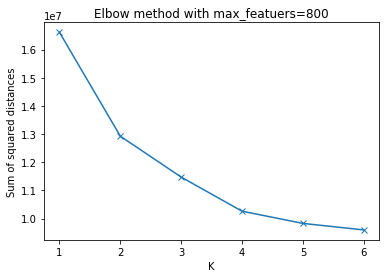

In [16]:
plt.plot(range(1,7), [KMeans(n_clusters = 1).fit(df_cv_norm).inertia_]+sse, 'x-')
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method with max_featuers=800')

Text(0.5, 1.0, 'Silhouette method with max_featuers=800')

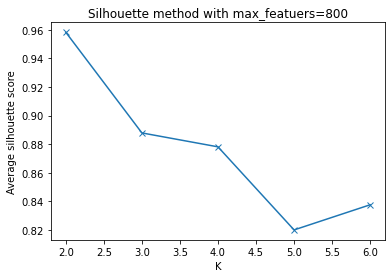

In [15]:
plt.plot(K, silhouette_avg, 'x-')
plt.xlabel('K')
plt.ylabel('Average silhouette score')
plt.title('Silhouette method with max_featuers=800')

The plot tells a lot. With some pre-knowledge, the lyrics belong two major categories - hit song and non-hit song. Therefore, there is an elbow point at $k=2$. But hit and non-hit seems not sufficient. Both methods suggest $k=4$ is also somehow reasonable because it is possible that different genre may produce different styles of lyrics. 

In [17]:
# Use TfidfVectorizer
sse = []
silhouette_avg = []
K = range(2,7)

for k in K:
    kmeans = KMeans(n_clusters = k).fit(df_tfidf)
    sse.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(df_tfidf, kmeans.predict(df_tfidf)))

Text(0.5, 1.0, 'Elbow method with max_featuers=800')

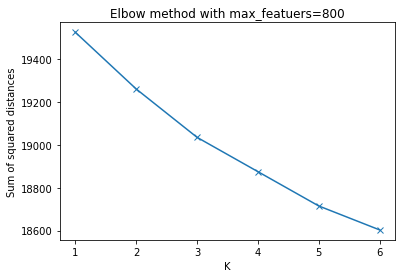

In [18]:
plt.plot(range(1,7), [KMeans(n_clusters = 1).fit(df_tfidf).inertia_]+sse, 'x-')
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method with max_featuers=800')

Text(0.5, 1.0, 'Silhouette method with max_featuers=800')

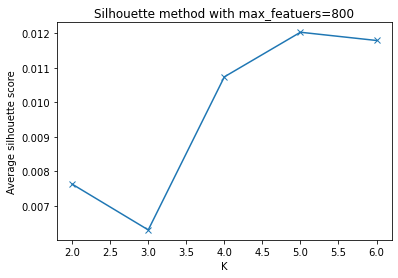

In [19]:
plt.plot(K, silhouette_avg, 'x-')
plt.xlabel('K')
plt.ylabel('Average silhouette score')
plt.title('Silhouette method with max_featuers=800')

Using TfidfVectorizer, $k=3$ gives a clear elbow. This makes sense because there might be songs pretty poplular but do not feature on Billboard Hot 100 charts.

#### *k=2* with CounterVectorizer

In [20]:
model_2 = KMeans(n_clusters = 2)
model_2.fit(df_cv_norm)

0.17224287484510534

In [24]:
# accuracy
sum(model_2.labels_ == song_lyrics['hit'])/len(song_lyrics)

0.8277571251548946

Cluster visualization using TruncatedSVD

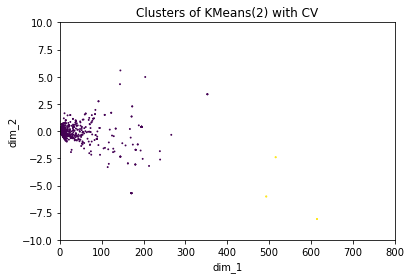

In [218]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=3, random_state=42)
dtm_cv_3d = svd.fit_transform(dtm_cv)

plt.figure(figsize=(6,4))
plt.scatter(dtm_cv_3d[:, 1], dtm_cv_3d[:, 2], s=0.8, c=model_2.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.xlim(0,800)
plt.ylim(-10,10)
plt.title('Clusters of KMeans(2) with CV')
plt.show()

In [87]:
model_2_t = KMeans(n_clusters = 2)
model_2_t.fit(df_cv)

# accuracy
sum(model_2_t.labels_ == song_lyrics['hit'])/len(song_lyrics)

0.8279001048517777

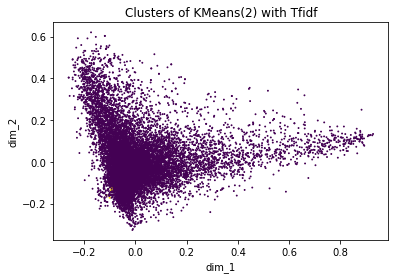

In [213]:
dtm_tfidf_3d = svd.fit_transform(dtm_tfidf)
plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.8, c=model_2_t.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Clusters of KMeans(2) with Tfidf')
plt.show()

The accuracy of KMeans clustering with $k=2$ is around $83\%$, which is not bad (because we cannot tell hit songs merely by the lyrics). The visualization of clsuters does not reveal too much information when $k=2$, as most of the songs are non-hit songs and only 3300 are hit songs; therefore, the majorities are purple points (non-hit songs). Specifically, when comparing CountVectorizer and TfidfVectorizer, the clustering results given by TfidfVectorizer is much more staisfying than CountVectorizer, as it is more centered.

Let's try more number of clusters.

#### *k=3*

In [82]:
# CountVectorizer
model_3 = KMeans(n_clusters = 3)
model_3.fit(df_cv)

# TfidfVectorizer
model_3_t = KMeans(n_clusters = 3)
model_3_t.fit(df_tfidf)

KMeans(n_clusters=3)

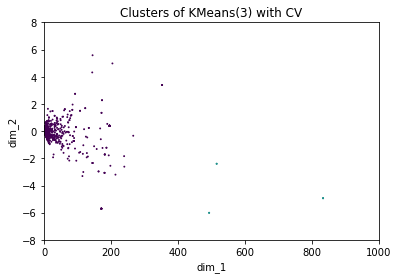

In [176]:
plt.figure(figsize=(6,4))
plt.scatter(dtm_cv_3d[:, 1], dtm_cv_3d[:, 2], s=0.8, c=model_3.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.xlim(-1,1000)
plt.ylim(-8,8)
plt.title('Clusters of KMeans(3) with CV')
plt.show()

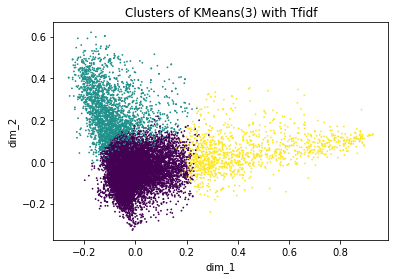

In [215]:
plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=model_3_t.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Clusters of KMeans(3) with Tfidf')
plt.show()

Aligned with what is observed using $k=2$, the clusters obtained using TfidfVectorizer are much more reliable than CountVectorizer when $k=3$. It can be easily seen that $k=3$ is a very good choice of number of clusters because cases in each group are tighly clustered without much overlapping.

#### *k=4*

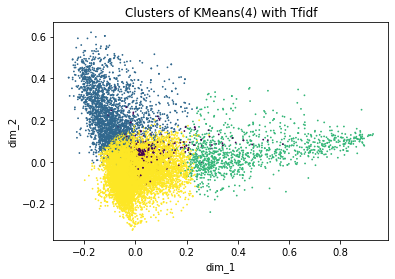

In [88]:
# TfidfVectorizer
model_4_t = KMeans(n_clusters = 4)
model_4_t.fit(df_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=model_4_t.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Clusters of KMeans(4) with Tfidf')
plt.show()

#### *k=5*

In [89]:
# CountVectorizer
model_5 = KMeans(n_clusters = 5)
model_5.fit(df_cv)

# TfidfVectorizer
model_5_t = KMeans(n_clusters = 5)
model_5_t.fit(df_tfidf)

KMeans(n_clusters=5)

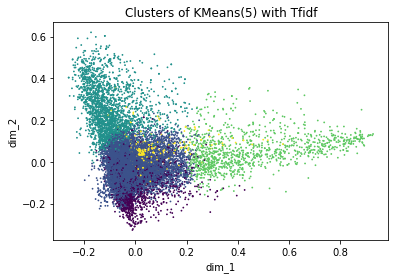

In [32]:
plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=model_5_t.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Clusters of KMeans(5) with Tfidf')
plt.show()

$k=5$ might not be a good idea, since the seperation does not seem maximized as $k=3$.

### Hit and non-hit distribution in each cluster

In [97]:
sub = song_lyrics.copy()
sub['label_2'] = model_2_t.labels_
sub.groupby(['label_2','hit'])[['title']].count()

title
label_2 hit       
0       0.0  17371
        1.0   3595
1       0.0     16

In [98]:
sub['label_3'] = model_3_t.labels_
sub.groupby(['label_3','hit'])[['title']].count()

title
label_3 hit       
0       0.0  14903
        1.0   2274
1       0.0    953
        1.0    245
2       0.0   1531
        1.0   1076

In [99]:
sub['label_4'] = model_4_t.labels_
sub.groupby(['label_4','hit'])[['title']].count()

title
label_4 hit       
0       0.0    260
        1.0    139
1       0.0   1492
        1.0   1065
2       0.0    935
        1.0    233
3       0.0  14700
        1.0   2158

In [100]:
sub['label_5'] = model_5_t.labels_
sub.groupby(['label_5','hit'])[['title']].count()

title
label_5 hit       
0       0.0  13449
        1.0   1948
1       0.0    909
        1.0    225
2       0.0   1425
        1.0    280
3       0.0   1346
        1.0   1003
4       0.0    258
        1.0    139

### Wordcloud of each cluster

$k = 3$

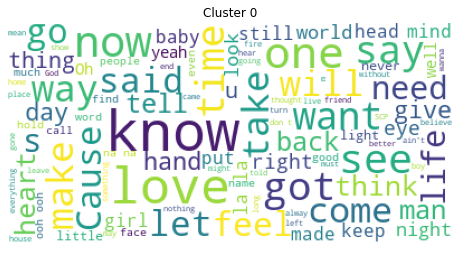

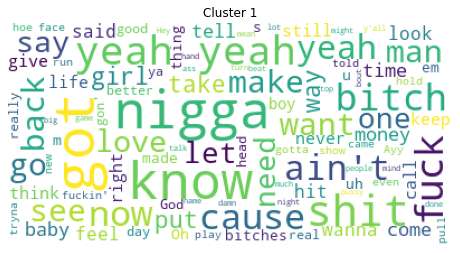

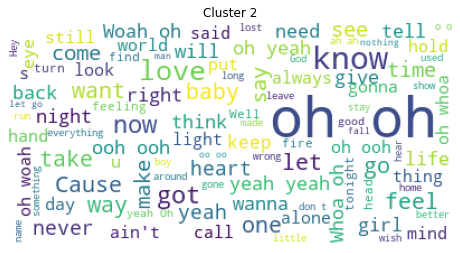

In [206]:
song_lyrics['label_3'] = model_3_t.labels_
for i in range(3):
    text = ' '.join(song_lyrics.loc[song_lyrics['label_3']==i, 'lyrics'])
    plt.figure(figsize=(8,6))
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Cluster %s' %i)
    plt.show()

## Hierarchical clustering

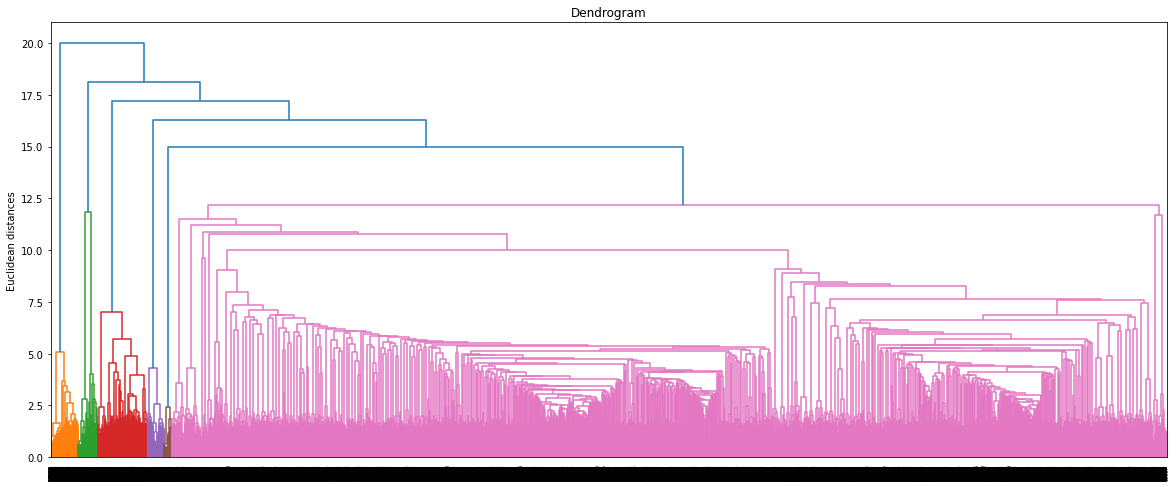

In [272]:
# Use all data points
plt.figure(figsize=(20,8))
dendrogram = sch.dendrogram(sch.linkage(df_tfidf, method  = 'ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show()

#### *n_clusters=5*

In [68]:
hc_euc = AgglomerativeClustering(n_clusters=5,
                             affinity = 'euclidean',
                             linkage = 'single')

hc_euc.fit(df_tfidf)

AgglomerativeClustering(linkage='single', n_clusters=5)

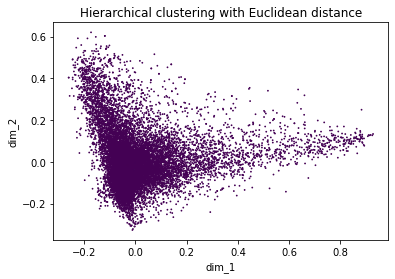

In [69]:
plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=hc_euc.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Hierarchical clustering with Euclidean distance')
plt.show()

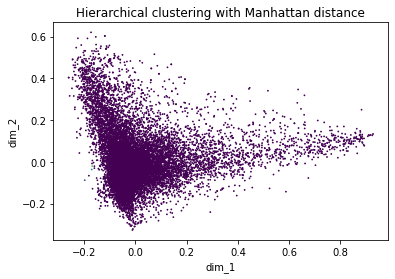

In [70]:
hc_man = AgglomerativeClustering(n_clusters=5,
                             affinity = 'manhattan',
                             linkage = 'single')

hc_man.fit(df_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=hc_man.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Hierarchical clustering with Manhattan distance')
plt.show()

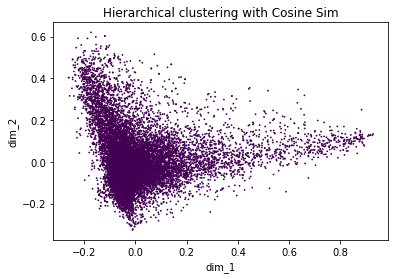

In [71]:
hc_cos = AgglomerativeClustering(n_clusters=5,
                             affinity = 'cosine',
                             linkage = 'single')

hc_cos.fit(df_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=hc_cos.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Hierarchical clustering with Cosine distance')
plt.show()

#### *n_clusters=8*

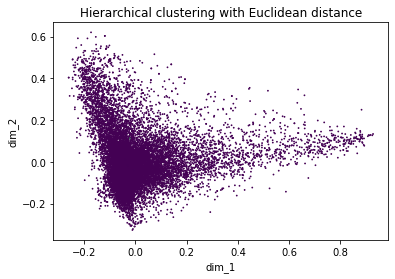

In [72]:
hc_euc = AgglomerativeClustering(n_clusters=8,
                             affinity = 'euclidean',
                             linkage = 'single')

hc_euc.fit(df_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=hc_euc.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Hierarchical clustering with Euclidean distance')
plt.show()

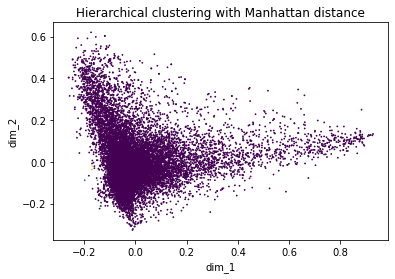

In [73]:
hc_man = AgglomerativeClustering(n_clusters=8,
                             affinity = 'manhattan',
                             linkage = 'single')

hc_man.fit(df_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=hc_man.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Hierarchical clustering with Manhattan distance')
plt.show()

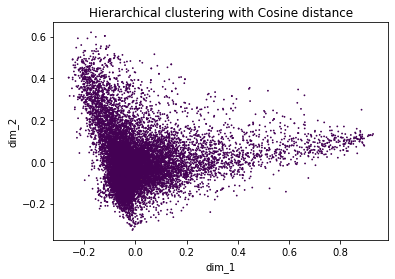

In [74]:
hc_cos = AgglomerativeClustering(n_clusters=8,
                             affinity = 'cosine',
                             linkage = 'single')

hc_cos.fit(df_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=hc_cos.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Hierarchical clustering with Cosine distance')
plt.show()

#### *n_clusters=10*

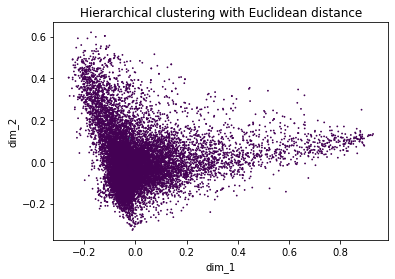

In [75]:
hc_euc = AgglomerativeClustering(n_clusters=10,
                             affinity = 'euclidean',
                             linkage = 'single')

hc_euc.fit(df_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=hc_euc.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Hierarchical clustering with Euclidean distance')
plt.show()

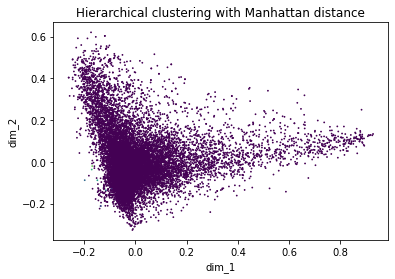

In [76]:
hc_man = AgglomerativeClustering(n_clusters=10,
                             affinity = 'manhattan',
                             linkage = 'single')

hc_man.fit(df_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=hc_man.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Hierarchical clustering with Manhattan distance')
plt.show()

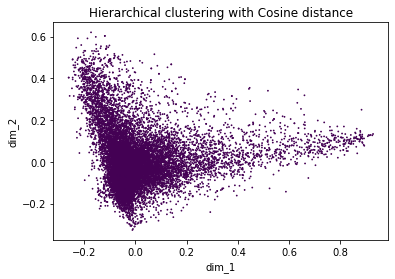

In [77]:
hc_cos = AgglomerativeClustering(n_clusters=10,
                             affinity = 'cosine',
                             linkage = 'single')

hc_cos.fit(df_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=hc_cos.labels_)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('Hierarchical clustering with Cosine distance')
plt.show()

In [101]:
sub['label_10_hc'] = hc_euc.labels_
sub.groupby(['label_10_hc','hit'])[['title']].count()

title
label_10_hc hit       
0           0.0  17363
            1.0   3591
1           0.0      1
            1.0      1
2           0.0     17
            1.0      1
3           0.0      1
4           0.0      1
5           1.0      2
6           0.0      1
7           0.0      1
8           0.0      1
9           0.0      1

## DBSCAN

Determine epsilon

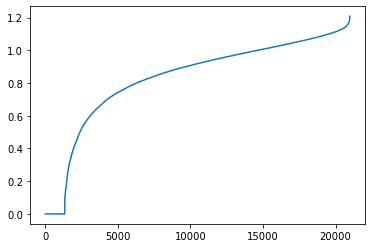

In [256]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=3).fit(dtm_tfidf)
distances, indices = nbrs.kneighbors(dtm_tfidf)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

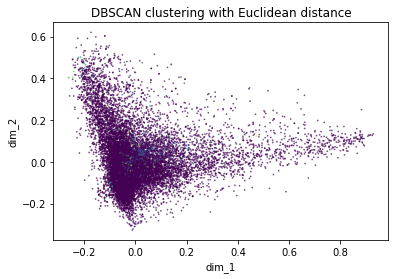

In [269]:
db_euc = DBSCAN(eps=0.62, metric='euclidean', n_jobs=-1)
db_euc.fit(dtm_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=db_euc.labels_, alpha=0.6)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('DBSCAN clustering with Euclidean distance')
plt.show()

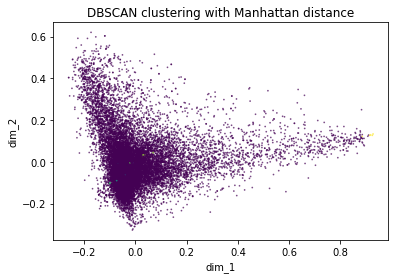

In [270]:
db_man = DBSCAN(eps=0.62, metric='manhattan', n_jobs=-1)
db_man.fit(dtm_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=db_man.labels_, alpha=0.6)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('DBSCAN clustering with Manhattan distance')
plt.show()

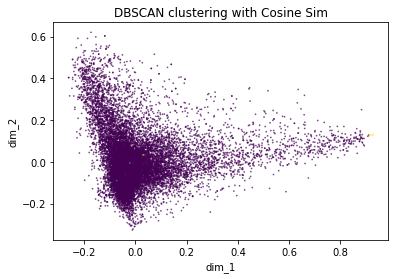

In [271]:
db_cos = DBSCAN(eps=0.62, metric='manhattan', n_jobs=-1)
db_cos.fit(dtm_tfidf)

plt.figure(figsize=(6,4))
plt.scatter(dtm_tfidf_3d[:, 1], dtm_tfidf_3d[:, 2], s=0.6, c=db_cos.labels_, alpha=0.6)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('DBSCAN clustering with Cosine Sim')
plt.show()